In [1]:
import biom
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Microbiome

In [2]:
instruments = pd.read_table('../data/instrument.txt', index_col=0)
phenotype = pd.read_table('../data/phenotype.txt', index_col=0)

In [3]:
table = biom.load_table('../data/hcc-data/46119_otu_table.biom').to_dataframe().T

confounder = pd.read_csv('../data/cleaned-data/microbiome_confounder.csv', index_col=0)
family = pd.read_csv('../data/cleaned-data/microbiome_family.csv', index_col=0)
instrument = pd.read_csv('../data/cleaned-data/microbiome_instrume.csv', index_col=0)
outcome = pd.read_csv('../data/cleaned-data/microbiome_outcome.csv', index_col=0)

outcome.index = family.index # fingers crossed!
instrument.index = family.index 
confounder.index = family.index 
table = table.loc[family.index]

# read in loadings from IV analysis
microbeV = pd.read_excel('../application/HCC/microbiome_analysis.xlsx', 
                         sheet_name='Figure V', index_col=0)
microbeV.index = list(map(str, microbeV.index))

Compute balances from ranks

In [4]:
microbe_ranks = microbeV['V1'].sort_values()
denom = microbe_ranks.loc[microbe_ranks < 0].index
num = microbe_ranks.loc[microbe_ranks > 0].index

balance = pd.DataFrame({
    'balance' : np.log(table[num] + 1).mean(axis=1) - np.log(table[denom] + 1).mean(axis=1)
})

microbe_md = pd.merge(outcome, balance, left_index=True, right_index=True)
microbe_md = pd.merge(microbe_md, confounder, left_index=True, right_index=True)
microbe_md = pd.merge(microbe_md, instruments, left_index=True, right_index=True)

Text(0.5, 0, 'obesity')

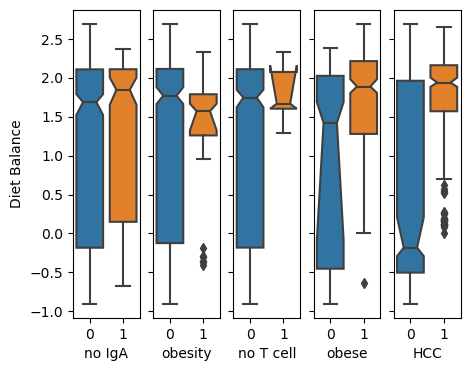

In [5]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(5, 4))

sns.boxplot(data=microbe_md, y='balance', x='no IgA', notch=True, ax=ax[0], bootstrap=1000)
sns.boxplot(data=microbe_md, y='balance', x='no B cell', notch=True, ax=ax[1], bootstrap=1000)
sns.boxplot(data=microbe_md, y='balance', x='no T cell', notch=True, ax=ax[2], bootstrap=1000)
sns.boxplot(data=microbe_md, y='balance', x='obese', notch=True, ax=ax[3], bootstrap=1000)
sns.boxplot(data=microbe_md, y='balance', x='HCC', notch=True, ax=ax[4], bootstrap=1000)

ax[0].set_ylabel('Diet Balance')
for i in range(1, 5):
    ax[i].set_ylabel('')
ax[1].set_xlabel('obesity')

Text(0.5, 0, 'Obese')

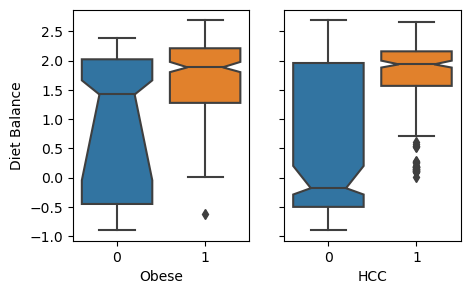

In [6]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 3))

sns.boxplot(data=microbe_md, y='balance', x='obese', notch=True, ax=ax[0], bootstrap=1000)
sns.boxplot(data=microbe_md, y='balance', x='HCC', notch=True, ax=ax[1], bootstrap=1000)

ax[0].set_ylabel('Diet Balance')
ax[1].set_ylabel('')
ax[0].set_xlabel('Obese')

Comparison against DESeq2 (both loadings and balances)

In [7]:
!ls ../application/HCC

deseq_metabolites.csv		      microbiome_analysis_otu.txt
deseq_microbiome.csv		      microbiome_analysis.xlsx
metabolites_analysis.txt	      microbiome_metabolites_data.xlsx
metabolites_analysis.xlsx	      microb_metabolites_analysis.xlsx
microbe_metabolites_analysis_otu.txt  plots


In [8]:
deseq2 = pd.read_csv('../application/HCC/deseq_microbiome.csv')
deseq2['OTU_id'] = deseq2['OTU_id'].astype(np.str)
deseq2_obese = deseq2.query("Phenotype == 'obese'").set_index('OTU_id')
deseq2_HCC = deseq2.query("Phenotype == 'HCC'").set_index('OTU_id')

deseq2_HCC['IV'] = microbe_ranks
deseq2_obese['IV'] = microbe_ranks

/tmp/ipykernel_13425/2451475731.py:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  deseq2['OTU_id'] = deseq2['OTU_id'].astype(np.str)


Text(0, 0.5, 'HCC log-fold change')

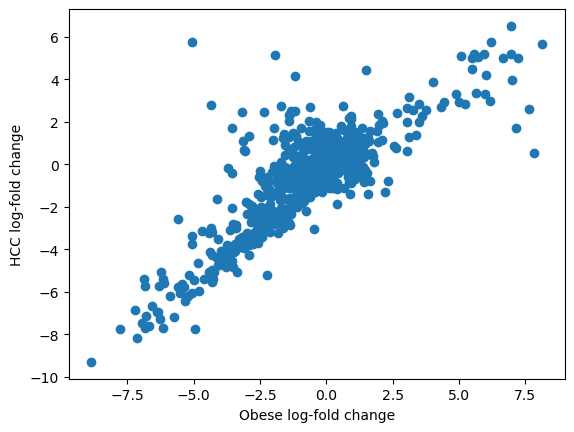

In [9]:
common_taxa = list(set(deseq2_obese.index) & set(deseq2_HCC.index))
plt.scatter(deseq2_obese.loc[common_taxa, 'log2FoldChange'], deseq2_HCC.loc[common_taxa, 'log2FoldChange'])
plt.xlabel('Obese log-fold change')
plt.ylabel('HCC log-fold change')

In [10]:
len(set(deseq2_HCC.index) & set(microbe_ranks.index))

709

654
709


/tmp/ipykernel_13425/4040191484.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax[0].scatter(deseq2_obese.loc[common_taxa, 'log2FoldChange'],
/tmp/ipykernel_13425/4040191484.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  microbe_ranks.loc[common_taxa])
/tmp/ipykernel_13425/4040191484.py:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax[1].scatter(deseq2_HCC.loc[common_taxa, 'log2FoldChange'],
/tmp/ipykernel_13425/4040191484.py:16: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  microbe_ranks.loc[common_taxa])


Text(0.5, 0, 'DESeq2 (HCC)')

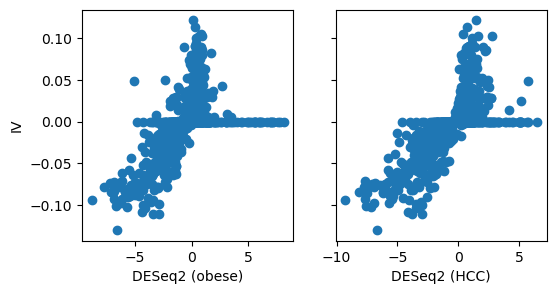

In [11]:
common_taxa = set(microbe_ranks.index) & set(deseq2_obese.index)
print(len(common_taxa))
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
ax[0].scatter(deseq2_obese.loc[common_taxa, 'log2FoldChange'], 
              microbe_ranks.loc[common_taxa])
ax[0].set_xlabel('DESeq2 (obese)')
ax[0].set_ylabel('IV')
#ax[0].set_xlim([-7, 7])
#ax[0].set_ylim([-0.4, 0.4])
#ax[0].plot([-5, 5], [-0.3, 0.3], 'r')

common_taxa = set(microbe_ranks.index) & set(deseq2_HCC.index)
print(len(common_taxa))

ax[1].scatter(deseq2_HCC.loc[common_taxa, 'log2FoldChange'], 
              microbe_ranks.loc[common_taxa])
ax[1].set_xlabel('DESeq2 (HCC)')
#ax[1].set_ylabel('GOFar')
#ax[1].set_xlim([-7, 7])
#ax[1].set_ylim([-0.4, 0.4])
#ax[1].plot([-5, 5], [-0.3, 0.3], 'r')

In [12]:
pos_idx = deseq2_HCC.query('log2FoldChange > 0 & IV > 0').index
zero_idx = deseq2_HCC.query('log2FoldChange > 0 & IV == 0').index
neg_idx = deseq2_HCC.query('log2FoldChange > 0 & IV < 0').index
total = len(deseq2_HCC.query('log2FoldChange > 0'))
print(len(neg_idx) / total, len(zero_idx) / total, len(pos_idx) / total)

0.011834319526627219 0.5118343195266272 0.47633136094674555


In [13]:
deseq2_HCC.loc[pos_idx].sort_values('IV')

,Unnamed: 0,Kingdom,Phylum,Class,Order,Family,Genus,Species,Phenotype,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,IV
OTU_id,,,,,,,,,,,,,,,,
4385479,2171,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacteriales,f__Enterobacteriaceae,g__Proteus,s__,HCC,0.930869,1.792852,0.651796,2.750636,5.947978e-03,1.289638e-02,0.000218
180555,2095,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Coprococcus,s__,HCC,4.042844,0.357460,0.266801,1.339801,1.803099e-01,2.663328e-01,0.000623
260205,2152,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__,g__,s__,HCC,1.678723,1.484634,0.672763,2.206770,2.733012e-02,5.072528e-02,0.000695
233817,2547,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__,g__,s__,HCC,31.032711,1.051902,0.290452,3.621610,2.927748e-04,8.833077e-04,0.000806
265940,2113,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Ruminococcus,s__,HCC,11.175730,0.848674,0.369857,2.294602,2.175594e-02,4.135379e-02,0.000873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261590,2007,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Peptostreptococcaceae,g__,s__,HCC,115.178767,2.753958,0.287791,9.569307,1.076244e-21,1.230737e-20,0.102071
258421,2428,k__Bacteria,p__Firmicutes,c__Erysipelotrichi,o__Erysipelotrichales,f__Erysipelotrichaceae,g__Allobaculum,s__,HCC,654.236321,1.647891,0.257500,6.399586,1.557987e-10,1.004193e-09,0.102987
262633,1955,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__[Ruminococcus],s__gnavus,HCC,306.960310,0.373817,0.249910,1.495808,1.347037e-01,2.091688e-01,0.105202


In [14]:
(deseq2_HCC
 .loc[microbe_ranks.loc[(microbe_ranks > 0)].index]
 .query('log2FoldChange < 0'))

,Unnamed: 0,Kingdom,Phylum,Class,Order,Family,Genus,Species,Phenotype,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,IV
98048,2147,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Oscillospira,s__,HCC,10.453519,-0.254806,0.385766,-0.660520,0.508920,0.630812,0.004972
2937207,2623,k__Bacteria,p__Deferribacteres,c__Deferribacteres,o__Deferribacterales,f__Deferribacteraceae,g__Mucispirillum,s__schaedleri,HCC,496.521325,-0.274969,0.231379,-1.188389,0.234680,0.330533,0.011205
181719,2000,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__,HCC,339.831488,-0.138655,0.206477,-0.671530,0.501883,0.623179,0.016493


Read in picrust pre-computed files

In [15]:
copy_num = pd.read_table('../data/picrust/16S_13_5_precalculated.tab')
copy_num['#OTU_IDs'] = copy_num['#OTU_IDs'].astype(np.str)
copy_num = copy_num.set_index('#OTU_IDs')
deseq2_HCC['16S_copy_num'] = copy_num.loc[deseq2_HCC.index]

/tmp/ipykernel_13425/2017979888.py:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  copy_num['#OTU_IDs'] = copy_num['#OTU_IDs'].astype(np.str)


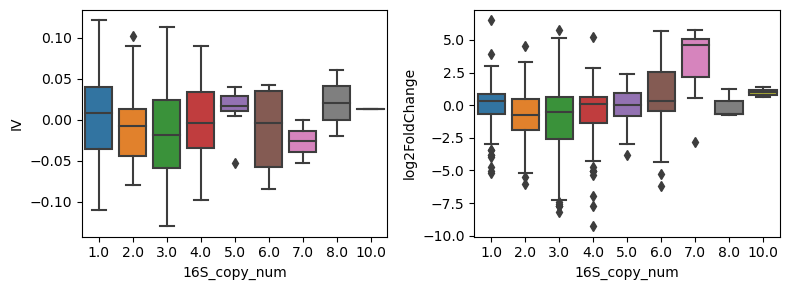

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.boxplot(data=deseq2_HCC.query('IV != 0'), x='16S_copy_num', y='IV', ax=ax[0])
sns.boxplot(data=deseq2_HCC, x='16S_copy_num', y='log2FoldChange', ax=ax[1])
plt.tight_layout()

Look into picrust KEGGs

In [18]:
t = biom.load_table('../data/picrust/ko_13_5_precalculated.biom')
kegg_cats = pd.read_table('../data/picrust/kegg_cats.tab', index_col=0).T.reset_index()
kegg_cats.index = t.ids()

# focus on relevant OTUs in KEGG
t2 = t.filter(lambda v, i, m: i in set(deseq2_HCC.index), axis='observation', inplace=False)
# pull out carbohydrate pathways
carb_keggs = kegg_cats.loc[kegg_cats['metadata_KEGG_Pathways'].apply(lambda x: 'Carbohydrate' in x)]
t3 = t2.filter(lambda v, i, m: i in set(carb_keggs.index), axis='sample', inplace=False)

carb_kegg_counts = t3.to_dataframe().sum(axis=1)
deseq2_HCC['carb_kegg_counts'] = carb_kegg_counts

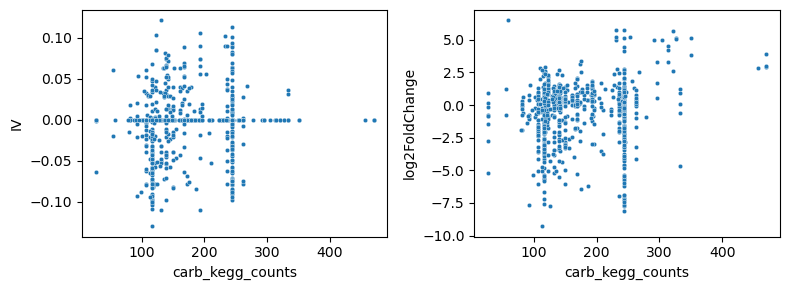

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.scatterplot(data=deseq2_HCC, x='carb_kegg_counts', y='IV', ax=ax[0], s=10)
sns.scatterplot(data=deseq2_HCC, x='carb_kegg_counts', y='log2FoldChange', ax=ax[1], s=10)
plt.tight_layout()

MMvec analysis

In [40]:
from skbio import OrdinationResults
ord_res = OrdinationResults.read(
    '../results/mmvec_results/latent_dim_5_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95_ordination.txt'
)
microbe_fmd = ord_res.features.rename(columns={0: 'PC1', 1: 'PC2', 2: 'PC3', 3: 'PC4', 4: 'PC5'})
metabolite_fmd = ord_res.samples.rename(columns={0: 'PC1', 1: 'PC2', 2: 'PC3', 3: 'PC4', 4: 'PC5'})
deseq2_HCC = pd.merge(deseq2_HCC, microbe_fmd, left_index=True, right_index=True)

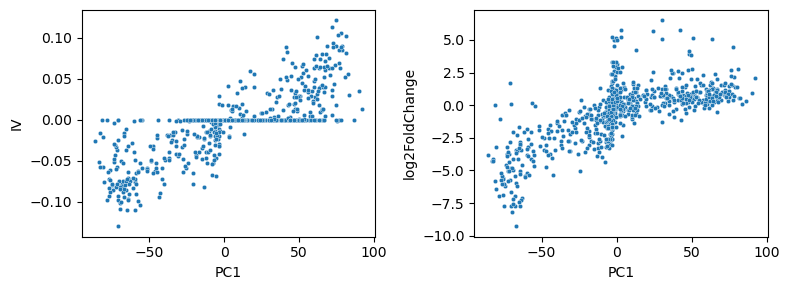

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.scatterplot(data=deseq2_HCC, x='PC1', y='IV', ax=ax[0], s=10)
sns.scatterplot(data=deseq2_HCC, x='PC1', y='log2FoldChange', ax=ax[1], s=10)
plt.tight_layout()

/tmp/ipykernel_13425/1991049484.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(metabolite_fmd.PC1)


<AxesSubplot: xlabel='PC1', ylabel='Density'>

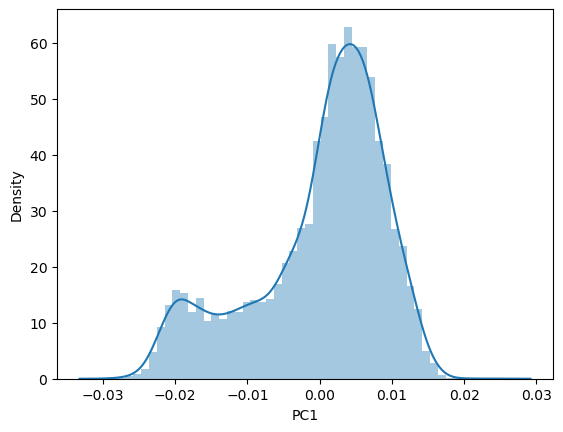

In [44]:
sns.distplot(metabolite_fmd.PC1)

In [70]:
metabolite_md = pd.read_table('../data/hcc-data/metabolite_feature_metadata.txt', index_col=0)
pc1_md = metabolite_md.reindex(metabolite_fmd.query("PC1 < 0").index).dropna(subset='Compound_Name')
pc1_md.loc[pc1_md['Compound_Name'].apply(lambda x: 'cholic' in x)]

,Intercept,diet[T.NC],mz,rt,nearest_distance,scan,Adduct,CAS_Number,Charge,Compound_Name,...,motif_478,motif_338,gnps_motif_43.m2m http://ms2lda.org/motifdb/motif/151021 Water loss - indicative of a free hydroxyl group – (in beer often seen in sugary structures),motif_388,motif_306,gnps_motif_38.m2m http://ms2lda.org/motifdb/motif/151045 Loss of CH2O2 - indicative for underivatized carboxilic acid group,motif_559,motif_451,motif_443,motif_469
374.277708609222_6.82141111111111,2.363873,0.167122,374.277709,409.284667,6.955577,2913.0,M+H-H2O,83498,1.0,Spectral Match to Hyodeoxycholic acid from NIST14,...,False,False,False,False,False,False,False,False,False,True
360.310161345639_7.9219421859545,0.173500,4.339013,360.310161,475.316531,7.658185,1846.0,M+H-H2O,434139,1.0,Spectral Match to Lithocholic acid from NIST14,...,False,False,False,False,False,False,False,False,False,False
358.33107535175_7.83839125964009,0.034493,0.807396,358.331075,470.303476,12.640255,1846.0,M+H-H2O,434139,1.0,Spectral Match to Lithocholic acid from NIST14,...,False,False,False,False,False,False,False,False,False,False
359.287519552607_7.94160298245613,-0.064785,0.288536,359.287520,476.496179,6.410824,1846.0,M+H-H2O,434139,1.0,Spectral Match to Lithocholic acid from NIST14,...,False,False,False,False,False,False,False,False,False,False
390.271330210572_6.42422523148147,0.783266,0.216381,390.271330,385.453514,13.452683,3527.0,M+H,5130290,1.0,Spectral Match to 12-Ketodeoxycholic acid from...,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376.30359939999_6.90328919753086,-2.800065,3.170483,376.303599,414.197352,11.837911,2913.0,M+H-H2O,83498,1.0,Spectral Match to Hyodeoxycholic acid from NIST14,...,False,False,False,False,False,False,False,False,False,True
390.265335965471_6.0829833912037,-0.491740,0.330469,390.265336,364.979003,7.133108,3527.0,M+H,5130290,1.0,Spectral Match to 12-Ketodeoxycholic acid from...,...,False,False,False,True,False,False,False,False,False,False
355.281389018206_8.19447559115179,0.305054,0.844329,355.281389,491.668535,9.636677,1846.0,M+H-H2O,434139,1.0,Spectral Match to Lithocholic acid from NIST14,...,False,False,False,False,False,False,False,False,False,False
390.309509576512_6.0911211622807,-3.870671,3.689467,390.309510,365.467270,6.643589,3527.0,M+H,5130290,1.0,Spectral Match to 12-Ketodeoxycholic acid from...,...,False,False,False,True,False,False,False,False,False,False


In [72]:
pc1_md = metabolite_md.reindex(metabolite_fmd.query("PC1 > 0").index).dropna(subset='Compound_Name')
pc1_md.loc[pc1_md['Compound_Name'].apply(lambda x: 'cholic' in x)]

,Intercept,diet[T.NC],mz,rt,nearest_distance,scan,Adduct,CAS_Number,Charge,Compound_Name,...,motif_478,motif_338,gnps_motif_43.m2m http://ms2lda.org/motifdb/motif/151021 Water loss - indicative of a free hydroxyl group – (in beer often seen in sugary structures),motif_388,motif_306,gnps_motif_38.m2m http://ms2lda.org/motifdb/motif/151045 Loss of CH2O2 - indicative for underivatized carboxilic acid group,motif_559,motif_451,motif_443,motif_469
357.278921944848_6.78255773651635,6.639105,1.608602,357.278922,406.953464,7.800464,1573.0,M+H-2H2O,474259,1.0,Spectral Match to Chenodeoxycholic acid from N...,...,False,False,False,False,False,False,False,False,False,False
375.289157255286_6.79100745149911,6.507710,-0.640123,375.289157,407.460447,5.057447,2913.0,M+H-H2O,83498,1.0,Spectral Match to Hyodeoxycholic acid from NIST14,...,False,False,False,False,False,False,False,False,False,True
391.284342734904_6.30942060301507,5.712242,-0.436180,391.284343,378.565236,6.526236,3527.0,M+H,5130290,1.0,Spectral Match to 12-Ketodeoxycholic acid from...,...,False,False,False,True,False,False,False,False,False,False
391.284181818993_6.01933271747497,3.890984,-0.359211,391.284182,361.159963,10.879037,3527.0,M+H,5130290,1.0,Spectral Match to 12-Ketodeoxycholic acid from...,...,False,False,False,True,False,False,False,False,False,False
375.288870609301_6.23114208037824,4.330831,-0.678197,375.288871,373.868525,2.463525,2953.0,M+H-H2O,128132,1.0,Spectral Match to Ursodeoxycholic acid from NI...,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451.34115796293_6.14762242729306,-1.288964,-0.162595,451.341158,368.857346,12.780127,4987.0,M+H,360656,1.0,Spectral Match to Glycodeoxycholic acid from N...,...,False,False,False,False,False,False,False,False,False,True
502.290347980056_5.53065465020576,-0.587407,-0.562756,502.290348,331.839279,10.442931,5690.0,M+H,14605222,1.0,Spectral Match to Tauroursodeoxycholic acid fr...,...,False,False,False,False,False,False,False,False,False,False
356.264861490475_6.84747592165899,0.816756,-0.367746,356.264861,410.848555,11.739442,1573.0,M+H-2H2O,474259,1.0,Spectral Match to Chenodeoxycholic acid from N...,...,False,False,False,False,False,False,False,False,False,False
502.293376851044_5.35832275641025,-0.546957,-0.965975,502.293377,321.499365,1.991306,5690.0,M+H,14605222,1.0,Spectral Match to Tauroursodeoxycholic acid fr...,...,False,False,False,False,False,False,False,False,False,False


In [49]:
metabolite_md

,sampleid,Intercept,diet[T.NC],mz,rt,nearest_distance,scan,Adduct,CAS_Number,Charge,...,motif_478,motif_338,gnps_motif_43.m2m http://ms2lda.org/motifdb/motif/151021 Water loss - indicative of a free hydroxyl group – (in beer often seen in sugary structures),motif_388,motif_306,gnps_motif_38.m2m http://ms2lda.org/motifdb/motif/151045 Loss of CH2O2 - indicative for underivatized carboxilic acid group,motif_559,motif_451,motif_443,motif_469
0,357.278921944848_6.78255773651635,6.639105,1.608602,357.278922,406.953464,7.800464,1573.0,M+H-2H2O,474259,1.0,...,False,False,False,False,False,False,False,False,False,False
1,375.289157255286_6.79100745149911,6.507710,-0.640123,375.289157,407.460447,5.057447,2913.0,M+H-H2O,83498,1.0,...,False,False,False,False,False,False,False,False,False,True
2,373.273770443826_5.10086137440758,6.333313,-0.131551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
3,373.273686528335_4.84083244725738,6.188790,-0.026041,373.273687,290.449947,9.800209,2573.0,M+H,NaN,1.0,...,False,False,False,False,False,False,False,False,False,False
4,391.284342734904_6.30942060301507,5.712242,-0.436180,391.284343,378.565236,6.526236,3527.0,M+H,5130290,1.0,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11929,361.272818801043_8.38321917077176,-0.903152,-0.089544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
11930,545.791125197703_3.36571988382483,-0.781770,-0.546678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
11931,330.269609799664_6.23307150537634,-0.727299,-0.794258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
11932,584.36345704229_3.78418134199134,-0.561481,-0.732218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False


# Metabolomics

In [ ]:
import biom
metabolites = biom.load_table('../data/hcc-data/metabolites.biom').to_dataframe().T
metabolite_md = pd.read_table('../data/hcc-data/metabolite_feature_metadata.txt', index_col=0)
metaboliteV = pd.read_excel('../results/metabolites_analysis.xlsx', sheet_name='Figure V', index_col=0)
metabolite_md = metabolite_md.reset_index().dropna(subset=['Compound_Name'])
metabolite_md.index = metaboliteV.index

metabolites = metabolites[metabolite_md['sampleid'].values]
metabolites.columns = metabolite_md.index

metadata = pd.read_table('../data/hcc-data/cleaned_qiime_metadata.txt', index_col=0)

host_md = pd.read_table('../data/sample_information_from_prep_2458.tsv', index_col=0)
metadata = pd.merge(metadata, host_md[['host_subject_id']].reset_index(), 
                    left_index=True, right_on='host_subject_id')
metadata = pd.merge(metadata, microbe_md, left_on='sample_id', right_index=True)
metadata = metadata.set_index('host_subject_id')

In [ ]:
fig, ax = plt.subplots(figsize=(2, 8))
metabolite_ranks = metaboliteV['V2'].sort_values()
pd.DataFrame(metabolite_ranks.loc[np.abs(metabolite_ranks) > 0.065]).plot.barh(ax=ax)
ax.set_title('V2 : Immune Instrumental Variable')

In [ ]:
denom = metabolite_ranks.loc[metabolite_ranks < 0].index
num = metabolite_ranks.loc[metabolite_ranks > 0].index
v = pd.DataFrame({'balance' : np.log(metabolites[num] + 1).mean(axis=1) - np.log(metabolites[denom] + 1).mean(axis=1)})
metadata = pd.merge(metadata, v, left_index=True, right_index=True)

In [ ]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(5, 4))

sns.boxplot(data=metadata, y='balance', x='no IgA', notch=True, ax=ax[0], bootstrap=1000)
sns.boxplot(data=metadata, y='balance', x='no B cell', notch=True, ax=ax[1], bootstrap=1000)
sns.boxplot(data=metadata, y='balance', x='no T cell', notch=True, ax=ax[2], bootstrap=1000)
sns.boxplot(data=metadata, y='balance', x='obese_x', notch=True, ax=ax[3], bootstrap=1000)
sns.boxplot(data=metadata, y='balance', x='HCC_x', notch=True, ax=ax[4], bootstrap=1000)

ax[0].set_ylabel('V2 : Dietary Balance')
for i in range(1, 5):
    ax[i].set_ylabel('')
ax[1].set_xlabel('obesity')

In [ ]:
deseq2 = pd.read_csv('../results/deseq_metabolites.csv', index_col=0)
# deseq2 = pd.merge(deseq2, metabolite_md, 
deseq2_obese = deseq2.loc[deseq2['Phenotype'] == 'obese']
#deseq2_obese = deseq2_obese.set_index('Variable')

deseq2_HCC = deseq2.loc[deseq2['Phenotype'] == 'HCC']
#deseq2_HCC = deseq2_HCC.set_index('Variable')

# Merged microbe-metabolite datasets

In [ ]:
mmV = pd.read_excel('../results/microb_metabolites_analysis (1).xlsx', 
                    sheet_name='Figure V', index_col=0)

microbe_fmd = pd.read_excel('../results/microb_metabolites_analysis (1).xlsx', 
                    sheet_name='microbiome_meta', index_col=0)
metabolite_fmd = pd.read_excel('../results/microb_metabolites_analysis (1).xlsx', 
                               sheet_name='Metabolites_meta', index_col=0)

microbe_fmd['OTUID'] = list(map(lambda x: int(str(x)[1:]), microbe_fmd.index))

In [ ]:
bname = 'V3'
metabolite_ranks = metaboliteV2[bname].sort_values()
denom = metabolite_ranks.loc[metabolite_ranks < 0].index
num = metabolite_ranks.loc[metabolite_ranks > 0].index
v = pd.DataFrame({
    f'metabolite{bname}' : np.log(metabolites[num] + 1).mean(axis=1) - np.log(metabolites[denom] + 1).mean(axis=1)
})
metabolite_samp_md = pd.merge(metadata, v, left_index=True, right_index=True)

In [ ]:
fig, ax = plt.subplots(figsize=(2, 8))
pd.DataFrame(metabolite_ranks.loc[np.abs(metabolite_ranks) > 0.03]).plot.barh(ax=ax)
ax.set_title('V2 : Immune Instrumental Variable')

In [ ]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(5, 4))

sns.boxplot(data=metabolite_samp_md, y=f'metabolite{bname}', x='no IgA', notch=True, ax=ax[0], bootstrap=1000)
sns.boxplot(data=metabolite_samp_md, y=f'metabolite{bname}', x='no B cell', notch=True, ax=ax[1], bootstrap=1000)
sns.boxplot(data=metabolite_samp_md, y=f'metabolite{bname}', x='no T cell', notch=True, ax=ax[2], bootstrap=1000)
sns.boxplot(data=metabolite_samp_md, y=f'metabolite{bname}', x='obese_x', notch=True, ax=ax[3], bootstrap=1000)
sns.boxplot(data=metabolite_samp_md, y=f'metabolite{bname}', x='HCC_x', notch=True, ax=ax[4], bootstrap=1000)

ax[0].set_ylabel(f'Metabolite {bname} : Immune Balance')
for i in range(1, 5):
    ax[i].set_ylabel('')
ax[1].set_xlabel('obesity')

In [ ]:
bname = 'V3'
microbe_ranks = microbeV2[bname].sort_values()
denom = microbe_ranks.loc[microbe_ranks < 0].index
num = microbe_ranks.loc[microbe_ranks > 0].index
v = pd.DataFrame({
    f'microbe{bname}' : np.log(family[num] + 1).mean(axis=1) - np.log(family[denom] + 1).mean(axis=1)
})
microbe_samp_md = pd.merge(microbe_md, v, left_index=True, right_index=True)

# Cross-reference against MMvec

In [ ]:
metabolite_fmd

In [ ]:
mmvec_metab = res.samples.loc[]